# Make Pie Chart Visualisation

In [1]:
#Import Packages
import numpy as np
import cv2
import os
import random
import sys
import glob
import tqdm
import matplotlib.pyplot as plt 
from pathlib import Path
import torch
import math

from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.patches import Rectangle #changed

import imageio
import pandas as pd
import seaborn as sns
import scipy.io
import ntpath
from tqdm.notebook import tqdm

from collections import Counter
from scipy.io.arff import loadarff 

from utils.graphic_utils import *
from utils.detectron_utils import *
from utils.dataframe_utils import *

In [2]:
DF_FOLDER_DIR = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/df2'
df_folder_list = [df for df in glob.glob(DF_FOLDER_DIR + '/*')]
df_folder_list.sort()

In [3]:
df_folder_list

['/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/df2/beach',
 '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/df2/breite_strasse',
 '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/df2/bridge_1',
 '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/df2/bridge_2',
 '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/df2/bumblebee',
 '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/df2/doves',
 '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/df2/ducks_boat',
 '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/df2/ducks_children',
 '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/df2/golf',
 '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/df2/holsten_gate',
 '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/df2/koenigstrasse',
 '/Users/timschrod

## Combine Dataframes from all subjects

In [9]:
GAZEVID_DIR = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/LUEBECK/gaze_video/'
translate_dict = {'UNKNOWN':0, 'FIX':1, 'SACCADE':2, 'SP':3, 'NOISE':4}



videos_run = [s for s in range(1,14)]
#subjects_run = [0]#[s for s in range(0,17)]

markersize = 50
maxframes = 600

for v in tqdm(videos_run, desc="videos"):#len(video_path_list)
    for r in ['13.35','26.7']:
        df_dir = df_folder_list[v]
        video_name = os.path.basename(df_dir)
        df_path_list = [df for df in glob.glob(df_dir + '/*r='+r+'_mostSalient.pkl')]
        df_path_list.sort()

        df_total = pd.DataFrame()
            
        subjects_run = [s for s in range(len(df_path_list))]
        for s in tqdm(subjects_run, desc="subjects"):
            df_path = df_path_list[s]
            df = pd.read_pickle(df_path) #LOAD PICKLE
            filter = df["class_id"] != "" #delete rows with empty collumns
            df_short = df[filter]
            df_total = df_total.append(df_short, ignore_index = True) 
        if (r == '13.35'):
            DF_TOTAL_NAME = os.path.join(df_dir,'total_' + video_name + '_1°.pkl')
        else:
            DF_TOTAL_NAME = os.path.join(df_dir,'total_' + video_name + '_2°.pkl')

        df_total.to_pickle(DF_TOTAL_NAME)

## Make Graphics

In [5]:
videos_run = [s for s in range(5,18)]
GRAPHIC_DIR = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/graphics2/'
for v in tqdm(videos_run):
    for va in [1]: #for visual angle 1° & 2°
        df_dir = df_folder_list[v]
        video_name = os.path.basename(df_dir)
        DF_TOTAL_NAME = os.path.join(df_dir,'total_' + video_name + '_'+str(va)+'°.pkl')
        unpickled_df = pd.read_pickle(DF_TOTAL_NAME)
        graph_dir = GRAPHIC_DIR + video_name + '/'
        graph_name = video_name + '_'+str(va)+'°'
        if not os.path.isdir(graph_dir):
                os.mkdir(graph_dir)

        nested_pie_chart_panoptic(unpickled_df, graph_dir + graph_name + '_panoptic')
        nested_pie_chart_proto(unpickled_df, graph_dir + graph_name + '_proto')
        nested_pie_chart_walther_proto(unpickled_df, graph_dir + graph_name + '_walther_proto')
        df2 = unpickled_df.copy()
        df2['post_saccade_state'] = ''
        conditions = [
            (df2['thing'] == True) & (df2['motion_proto_id'] != 0), 
            (df2['thing'] == True) & (df2['motion_proto_id'] == 0),
            (df2['thing'] == False) & (df2['motion_proto_id'] != 0)
        ]
        choices = ['thing&proto','just thing', 'just proto']
        df2['post_saccade_state'] = np.select(conditions, choices, default='stuff&background')

        nested_pie_chart_total(df2, graph_dir + graph_name + '_total')

        d_sacc = merge_related_dp(df2, 'SACCADE')
        df_post_saccade = pd.DataFrame()
        for n in (d_sacc.SACCADE_id.unique()):  
            post_saccade_index = int((d_sacc[d_sacc.SACCADE_id == n].tail(1).index + 1).values)
            if ((post_saccade_index+9)<len(df2)):
                for i in range (post_saccade_index,post_saccade_index+9):
                    if ((df2.loc[i].handlabeller_final != 'SACCADE')):
                        df_post_saccade = df_post_saccade.append(df2.loc[i])
        nested_pie_chart_total(df_post_saccade, graph_dir + graph_name + '_total_40ms')
        

FileNotFoundError: [Errno 2] No such file or directory: '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/df2/st_petri_gate/total_st_petri_gate_1°.pkl'

In [12]:
DF_NAME = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/df2/breite_strasse/breite_strasse_AAF_595_r=13.35_mostSalient.pkl'
df = pd.read_pickle(DF_NAME)
df_short = df[df['handlabeller_final'] != 'NOISE']
df_short = df_short[df_short['handlabeller_final'] != 'SACCADE']
df_short['walther_proto_id'].value_counts()[df_short['walther_proto_id'].value_counts().index != 0]

2.0    815
1.0    414
3.0    367
4.0    132
5.0     90
Name: walther_proto_id, dtype: int64

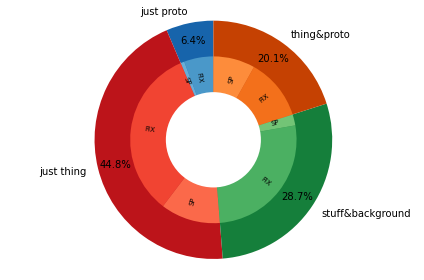

In [18]:
videos_run = [8,9,10]#[s for s in range(0,6)]
GRAPHIC_DIR = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/graphics/'
for v in tqdm(videos_run):
    for va in [1,2]: #for visual angle 1° & 2°
        df_dir = df_folder_list[v]
        video_name = os.path.basename(df_dir)
        DF_TOTAL_NAME = os.path.join(df_dir,'total_' + video_name + '_'+str(va)+'°.pkl')
        unpickled_df = pd.read_pickle(DF_TOTAL_NAME)
        graph_dir = GRAPHIC_DIR + video_name + '/'
        graph_name = video_name + '_'+str(va)+'°'
        if not os.path.isdir(graph_dir):
                os.mkdir(graph_dir)

        nested_pie_chart_panoptic(unpickled_df, graph_dir + graph_name + '_panoptic')
        nested_pie_chart_proto(unpickled_df, graph_dir + graph_name + '_proto')
        df2 = unpickled_df.copy()
        df2['post_saccade_state'] = ''
        conditions = [
            (df2['thing'] == True) & (df2['motion_proto_id'] != 0), 
            (df2['thing'] == True) & (df2['motion_proto_id'] == 0),
            (df2['thing'] == False) & (df2['motion_proto_id'] != 0)
        ]
        choices = ['thing&proto','just thing', 'just proto']
        df2['post_saccade_state'] = np.select(conditions, choices, default='stuff&background')

        nested_pie_chart_total(df2, graph_dir + graph_name + '_total')

        d_sacc = merge_related_dp(df2, 'SACCADE')
        df_post_saccade = pd.DataFrame()
        for n in (d_sacc.SACCADE_id.unique()):  
            post_saccade_index = int((d_sacc[d_sacc.SACCADE_id == n].tail(1).index + 1).values)
            if ((post_saccade_index+9)<len(df2)):
                for i in range (post_saccade_index,post_saccade_index+9):
                    if ((df2.loc[i].handlabeller_final != 'SACCADE')):
                        df_post_saccade = df_post_saccade.append(df2.loc[i])
        nested_pie_chart_total(df_post_saccade, graph_dir + graph_name + '_total_40ms')
        



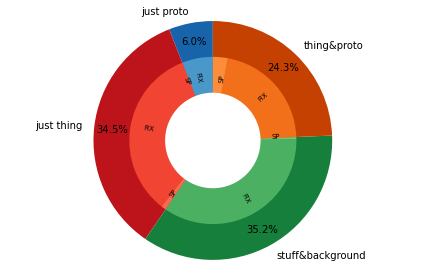

In [3]:
v=0
va=2 #or2
GRAPHIC_DIR = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/graphics/'
df_dir = df_folder_list[v]
video_name = os.path.basename(df_dir)
DF_TOTAL_NAME = os.path.join(df_dir,'total_' + video_name + '_'+str(va)+'°.pkl')
unpickled_df = pd.read_pickle(DF_TOTAL_NAME)
graph_dir = GRAPHIC_DIR + video_name + '/'
graph_name = video_name + '_'+str(va)+'°'
if not os.path.isdir(graph_dir):
        os.mkdir(graph_dir)

nested_pie_chart_panoptic(unpickled_df, graph_dir + graph_name + '_panoptic')
nested_pie_chart_proto(unpickled_df, graph_dir + graph_name + '_proto')
df2 = unpickled_df.copy()
df2['post_saccade_state'] = ''
conditions = [
    (df2['thing'] == True) & (df2['motion_proto_id'] != 0), 
    (df2['thing'] == True) & (df2['motion_proto_id'] == 0),
    (df2['thing'] == False) & (df2['motion_proto_id'] != 0)
]
choices = ['thing&proto','just thing', 'just proto']
df2['post_saccade_state'] = np.select(conditions, choices, default='stuff&background')

nested_pie_chart_total(df2, graph_dir + graph_name + '_total')

d_sacc = merge_related_dp(df2, 'SACCADE')
df_post_saccade = pd.DataFrame()
for n in (d_sacc.SACCADE_id.unique()):  
    post_saccade_index = int((d_sacc[d_sacc.SACCADE_id == n].tail(1).index + 1).values)
    for i in range (post_saccade_index,post_saccade_index+9):
        if ((df2.loc[i].handlabeller_final != 'SACCADE')):
            df_post_saccade = df_post_saccade.append(df2.loc[i])
nested_pie_chart_total(df_post_saccade, graph_dir + graph_name + '_total_40ms')





In [23]:
d_sacc = merge_related_dp(df2, 'SACCADE')
df_post_saccade = pd.DataFrame()
for n in (d_sacc.SACCADE_id.unique()):  
    post_saccade_index = int((d_sacc[d_sacc.SACCADE_id == n].tail(1).index + 1).values)
    for i in range (post_saccade_index,post_saccade_index+9):
        if ((df2.loc[i].handlabeller_final != 'SACCADE')):
            df_post_saccade = df_post_saccade.append(df2.loc[i])

In [ ]:
for n in (d_sacc.SACCADE_id.unique()):  
    post_saccade_index = int((d_sacc[d_sacc.SACCADE_id == n].tail(1).index + 1).values)
    for i in range (post_saccade_index,post_saccade_index+9):
        if (df2.loc[i].handlabeller_final != 'SACCADE'):
            df_post_saccade = df_post_saccade.append(df2.loc[i])
nested_pie_chart_total(df_post_saccade, DF_FOLDER_DIR + '/Z_graphics/' + video_name + '_total_40ms')

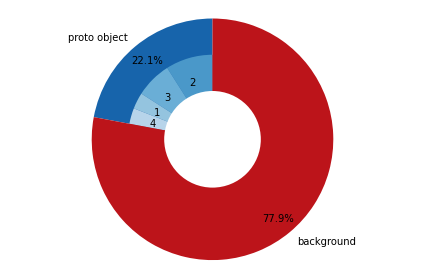

In [4]:
v = 0

df_dir = df_folder_list[v]
video_name = os.path.basename(df_dir)
DF_TOTAL_NAME = os.path.join(df_dir,'total_' + video_name + '.pkl')
unpickled_df = pd.read_pickle(DF_TOTAL_NAME)
nested_pie_chart_panoptic(unpickled_df, DF_FOLDER_DIR + '/Z_graphics/' + video_name + '_panoptic')
nested_pie_chart_proto(unpickled_df, DF_FOLDER_DIR + '/Z_graphics/' + video_name + '_proto')

In [ ]:
df2 = unpickled_df.copy()
df2['post_saccade_state'] = ''
conditions = [
    (df2['thing'] == True) & (df2['motion_proto_id'] != 0), 
    (df2['thing'] == True) & (df2['motion_proto_id'] == 0),
    (df2['thing'] == False) & (df2['motion_proto_id'] != 0)
]
choices = ['thing&proto','just thing', 'just proto']
df2['post_saccade_state'] = np.select(conditions, choices, default='stuff&background')

nested_pie_chart_total(df2, DF_FOLDER_DIR + '/Z_graphics/' + video_name + '_total')

unpickled_df = pd.read_pickle(DF_TOTAL_NAME)

## Post Saccdic

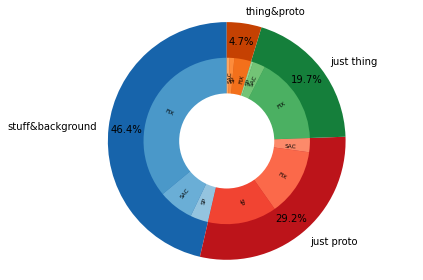

In [61]:
df2 = df2[df2['handlabeller_final'] != 'NOISE']
post_saccade_state = df2['post_saccade_state'].value_counts()

group_names=[*post_saccade_state.index[(post_saccade_state.index != '') & (post_saccade_state.index != 4)]]
group_size=[*post_saccade_state.values[(post_saccade_state.index != '') & (post_saccade_state.index != 4)]]

states = df2['post_saccade_state'].value_counts().index#[1:5]
subgroup_names = []
subgroup_size = []
for state in states:
    subgroup_names.append(df2[df2['post_saccade_state'] == state]['handlabeller_final'].value_counts().index)
    subgroup_size.append(df2[df2['post_saccade_state'] == state]['handlabeller_final'].value_counts().values)
subgroup_names = np.concatenate(subgroup_names)
subgroup_names[subgroup_names == 'SACCADE'] = ['SAC']
#subgroup_names[subgroup_names == 'NOISE'] = ['*']


 # Create colors
a, b, c, d =[plt.cm.Blues, plt.cm.Reds, plt.cm.Greens, plt.cm.Oranges]

color_list_1 = [a(0.6-0.1*x) for x in range(len(subgroup_size[0]))]
color_list_2 = [b(0.6-0.1*x) for x in range(len(subgroup_size[1]))]
color_list_3 = [c(0.6-0.1*x) for x in range(len(subgroup_size[2]))]
color_list_4 = [d(0.6-0.1*x) for x in range(len(subgroup_size[3]))]

subgroup_size = np.concatenate(subgroup_size)

bigger = plt.pie(group_size, labels=group_names, 
                startangle=90, frame=True, colors=[a(0.8),b(0.8),c(0.8),d(0.8)], autopct='%1.1f%%', pctdistance = 0.85)
smaller = plt.pie(subgroup_size, labels=subgroup_names,
                    colors=[*color_list_1,*color_list_2,*color_list_3,*color_list_4], radius=0.7,
                    startangle=90, labeldistance=0.7, rotatelabels = True, textprops = dict(size = 'xx-small'))
centre_circle = plt.Circle((0, 0), 0.4, color='white', linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
    
plt.axis('equal')
plt.axis('off')
#plt.title('Total Gaze Correlation for breite_strasse')
# save it
plt.tight_layout()
plt.savefig('/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/df/total_breite_strasse',dpi = 200)

# Area covered by proto objects / panoptic seg

In [130]:
import scipy.io as sio

D_DIR = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/panoptic-seg/'
RESULTS_DIR = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/'
detect_path_list = [video for video in glob.glob(RESULTS_DIR + 'detect_video/' + '*.avi')]
detect_path_list.sort()

data_path_list = [video for video in glob.glob(D_DIR + '*_data.npy')]
data_path_list.sort()
data_path_list

info_path_list = [video for video in glob.glob(D_DIR + '*_info.npy')]
info_path_list.sort()

v=1
videoloc = detect_path_list[v] #panoptic Segmented Video
#vid = imageio.get_reader(videoloc,  'ffmpeg')
vidlist = []


video_name = os.path.splitext(os.path.basename(videoloc))[0]
print(video_name)

motion_proto_path = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_code/proto-objects/salData/' + video_name + '.mat'
motion_proto = sio.loadmat(motion_proto_path)
motion_proto_maps = np.asarray(motion_proto['S'])

# load panoptic segmentation results
panoptic_seg = np.load(data_path_list[v], allow_pickle=True) # change storage.py line 134 for this
segments_info = np.load(info_path_list[v],allow_pickle=True) ## change back later!! to v



breite_strasse


In [175]:
total_mask = np.zeros((720, 1280))
for f in tqdm(range(len(panoptic_seg))):
    mask = np.zeros((720, 1280))
    for i in range(len(segments_info[f])):
        if segments_info[f][i]['isthing']:
            mask = mask + np.where((panoptic_seg[f]==i),1,0)
        else: 
            break
    total_mask = total_mask + mask

In [176]:
total_mask.mean()/len(panoptic_seg) # average area covered by panoptic segmentation

0.1785829957966303

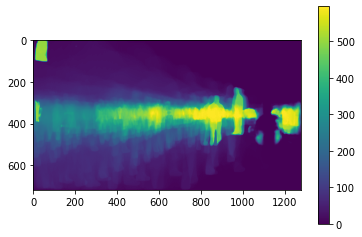

In [177]:
plt.imshow(total_mask)
plt.colorbar()

In [197]:
total_mask = np.zeros((720, 1280))
for f in tqdm(range(len(motion_proto_maps))):
    mask = np.zeros((720, 1280))
    for n in range(0,5):
        resized = cv2.resize(motion_proto_maps[f,:,:,n], (1280,720), interpolation = cv2.INTER_AREA)
        blur = cv2.blur(resized,(20,20))
        mask = mask + blur
    total_mask = total_mask + mask

In [198]:
total_mask.mean()/len(panoptic_seg)

0.06349292046805088

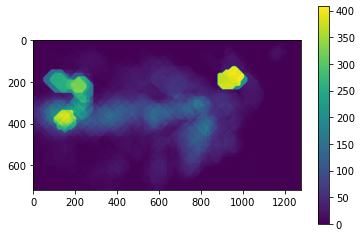

In [199]:
plt.imshow(total_mask)
plt.colorbar()
    

In [14]:
np.unique(blur)

233242

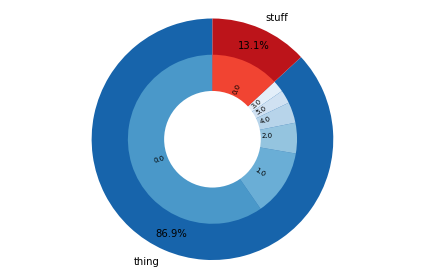

In [4]:
DF_NAME = '/Users/timschroder/Documents/Uni/Bachelorarbeit/project_results.nosync/df/breite_strasse/breite_strasse_AAF_595_r=13.35_mostSalient.pkl'
df = pd.read_pickle(DF_NAME)
filter = df["class_id"] != "" #delete rows with empty collumns
df_short = df[filter]
nested_pie_chart_salient_panoptic(df_short, 'test')

In [9]:
df_short.thing.value_counts()

True     4083
False     846
Name: thing, dtype: int64

In [7]:
#df_short[df_short['thing'] == True]['most_salient_object'].value_counts()
df_short[df_short['thing'] == False]['most_salient_object'].value_counts()

0.0    846
Name: most_salient_object, dtype: int64